# Manipulating tax-scales

In [ ]:
from openfisca_senegal import CountryTaxBenefitSystem as SenegalTaxBenefitSystem  # The Senegalese tax-benefits system
from openfisca_core.periods import period # Needed to specify the periods to modify the parameters

## Extract the tax-scale

In [ ]:
tax_benefit_system = SenegalTaxBenefitSystem()

In [ ]:
bareme_impot_progressif = tax_benefit_system.parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif

In [ ]:
bareme_impot_progressif

## Analyse the tax scale

In [ ]:
type(bareme_impot_progressif.brackets)

In [ ]:
len(bareme_impot_progressif.brackets)

It is a list of brackets.

## Analyse a bracket

In [ ]:
bracket = bareme_impot_progressif.brackets[3]
bracket

## Create a bracket

In [ ]:
from openfisca_core.parameters import Bracket

In [ ]:
another_bracket = Bracket(
    data = {
        'rate': {
            "2015-01-01": .1,
            "2013-01-01": .05
            },
        'threshold': {
            "2013-01-01": 1000
            }
        }
    )
another_bracket

## Modify the tax-scale

### Remove or add a bracket

Since it is a list we can delete an element ...

In [ ]:
del bareme_impot_progressif.brackets[5]

In [ ]:
len(bareme_impot_progressif.brackets)

In [ ]:
bareme_impot_progressif.brackets

... or add a bracket

In [ ]:
bareme_impot_progressif.brackets.insert(1, another_bracket)

In [ ]:
bareme_impot_progressif

### Modify a bracket of the tax-scale 

In [ ]:
bracket

In [ ]:
bareme_impot_progressif.brackets

In [ ]:
bracket.rate.update(start = period("2014-01-01"), stop = period("2015-12-31"), value = .33)
bracket

In [ ]:
bareme_impot_progressif

In [ ]:
bracket.threshold.update(start = period("2014-01-01"), stop = period("2015-12-31"), value = 5000000)

In [ ]:
bracket

In [ ]:
bareme_impot_progressif

# Microsimulation with artificial survey data 

In [2]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline

import numpy as np  # linear algebra and math
import pandas as pd  # data frames

from openfisca_core.model_api import *
from openfisca_senegal import CountryTaxBenefitSystem as SenegalTaxBenefitSystem  # The Senegalese tax-benefits system

from openfisca_senegal.survey_scenarios import SenegalSurveyScenario

In [3]:
%config Completer.use_jedi = False

## Building the artificial data

Sénégal is composed by almost 15 millions people dispatched in around 1.6 million household

In [4]:
household_weight = 100
size = int(1.6e6 / household_weight)
print(f"Size of the sample: {size}")
np.random.seed(seed = 42)

Size of the sample: 16000


We assume that 2/3 of the household heads are married and that only married households do have children. The mean number of children per household is 5 and is normally distributed

In [5]:
est_marie = np.random.binomial(1, .66, size = size)
est_celibataire = np.logical_not(est_marie)
nombre_enfants = np.maximum(
    est_marie * np.round(np.random.normal(5, scale = 3, size = size)),
    0,
    )

We assume that 80% of the population are wage earners.
We choose a mean wage of 5,000,000 CFA with a log normal ditribution.
Since 
$$ \text{mean wage}  = e^{\mu + \frac{\sigma ^ 2}{2}} $$ 
and
$$ \text{median wage} = e^\mu $$
we can compute the distribution according to the following expressions.

In [6]:
mean_wage = 5e6
median_wage = .75 * mean_wage
est_salarie = np.random.binomial(1, .8, size = size)
mu = np.log(median_wage)
sigma = np.sqrt(2 * np.log(mean_wage / median_wage))
salaire = (
    est_salarie * 
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )


We choose a mean pension of 2 500 000 CFA

In [7]:
mean_pension = 2.5e6
median_pension = .9 * mean_pension

In [8]:
mu = np.log(median_pension)
sigma = np.sqrt(2 * np.log(mean_pension / median_pension))
pension_retraite = (
    np.logical_not(est_salarie) *
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )

In [9]:
input_data_frame = pd.DataFrame({
    'est_marie': est_marie,
    'est_celibataire': est_celibataire,
    'nombre_enfants': nombre_enfants,
    'pension_retraite': pension_retraite,
    'salaire': salaire,
    'household_id': range(size),
    'household_role_index': 0,
    'household_weight': household_weight,
    'person_weight': household_weight,
    })

In [10]:
input_data_frame.salaire.mean()

4008298.953776269

In [11]:
input_data_frame.groupby(['est_marie', 'nombre_enfants'])['salaire'].max()

est_marie  nombre_enfants
0          0.0               4.871784e+07
1          0.0               4.291143e+07
           1.0               3.606132e+07
           2.0               3.648407e+07
           3.0               3.293302e+07
           4.0               4.195000e+07
           5.0               3.075793e+07
           6.0               5.483413e+07
           7.0               6.424664e+07
           8.0               3.203148e+07
           9.0               3.570505e+07
           10.0              4.950989e+07
           11.0              2.456670e+07
           12.0              1.746923e+07
           13.0              1.304396e+07
           14.0              2.211995e+07
           15.0              6.620455e+06
           16.0              0.000000e+00
           18.0              0.000000e+00
Name: salaire, dtype: float64

<Axes: >

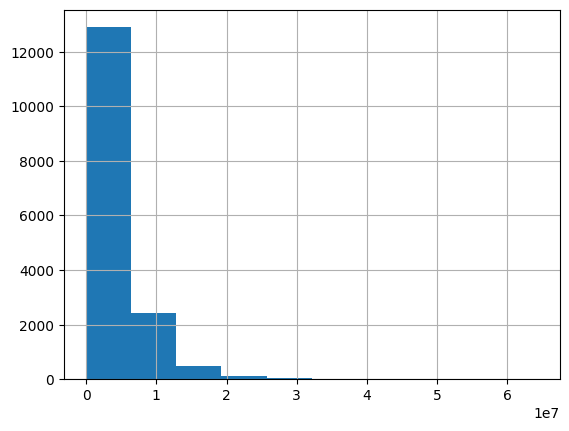

In [12]:
input_data_frame.salaire.hist()

<Axes: >

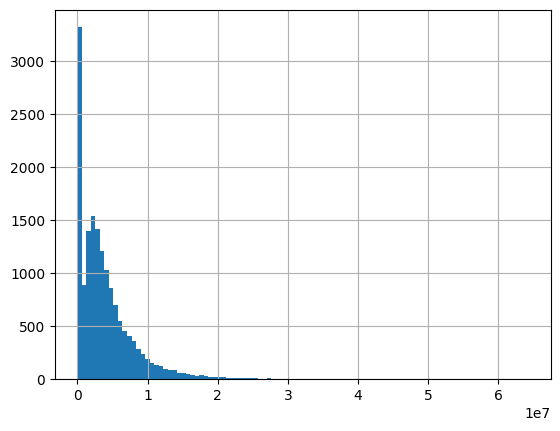

In [13]:
input_data_frame.salaire.hist(bins = 100)

<Axes: >

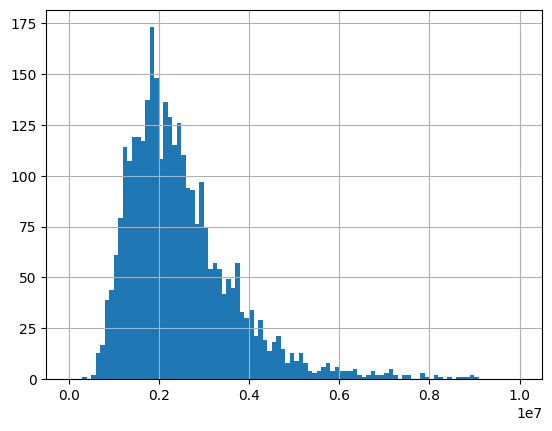

In [14]:
input_data_frame.pension_retraite.hist(bins=100, range = [.0001, 1e7])

## Microsimulation 

### Scenario

As with test case, we can build a scenario with survey data

In [15]:
data = dict(input_data_frame = input_data_frame)
scenario = SenegalSurveyScenario(
    data = data,
    year = 2017,
    )

In [16]:
scenario.tax_benefit_system.variables.keys()

dict_keys(['age', 'date_naissance', 'est_celibataire', 'est_divorce', 'est_marie', 'est_veuf', 'nombre_enfants', 'statut_marital', 'benefices_non_salarie', 'conjoint_a_des_revenus', 'pension_retraite', 'salaire', 'household_weight', 'person_weight', 'impot_avant_reduction_famille', 'impot_revenus', 'nombre_de_parts', 'reduction_impots_pour_charge_famille', 'impots_indirects'])

We can compute the value of any variable for the whole population and draw distributions

In [17]:
scenario.simulation.calculate('impot_revenus', period = 2017)

array([     0., 221100., 974400., ..., 233100., 933800., 309600.],
      dtype=float32)

In [18]:
df = pd.DataFrame(
    {'impot_revenus': scenario.simulation.calculate('impot_revenus', period = 2017)}
)

array([[<Axes: title={'center': 'impot_revenus'}>]], dtype=object)

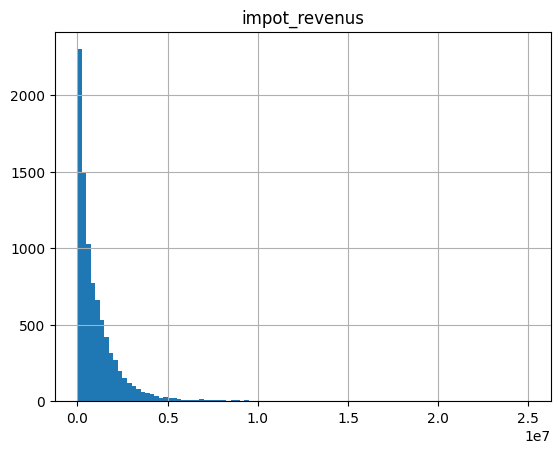

In [19]:
df.hist(bins = 100, range = [.00001, 2.5e7])

### Special scenario methods allow access to aggregates and pivot tables

In [20]:
scenario.weight_variable_by_entity = {'person': 'person_weight', 'household': 'household_weight'}

In [21]:
scenario.compute_aggregate('impot_revenus', period = 2017) / 1e9

967.3534237

In [22]:
df = scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    )
df

nombre_enfants,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18
impot_revenus,5.126755e+11,4.151655e+10,4.884427e+10,5.980575e+10,6.326998e+10,6.258805e+10,5.272029e+10,4.296910e+10,2.898208e+10,2.275353e+10,1.807866e+10,6.529531e+09,4.070463e+09,1.557763e+09,919261504.0,72600000.0,0.0,0.0


In [23]:
df.transpose().reset_index()

,nombre_enfants,impot_revenus
0,0,5.126755e+11
1,1,4.151655e+10
2,2,4.884427e+10
3,3,5.980575e+10
4,4,6.326998e+10
5,5,6.258805e+10
6,6,5.272029e+10
7,7,4.296910e+10
8,8,2.898208e+10
9,9,2.275353e+10


<Axes: xlabel='nombre_enfants'>

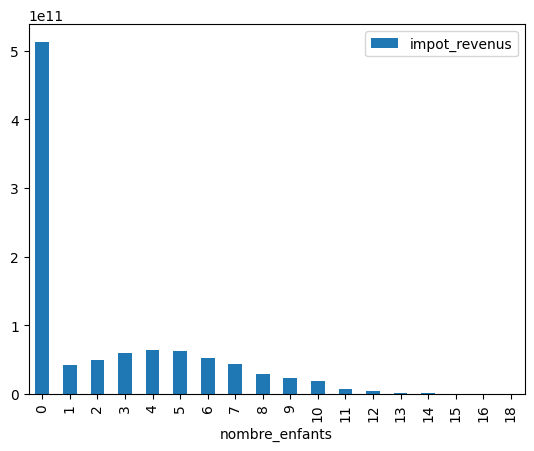

In [24]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    ).transpose().reset_index().plot(x = 'nombre_enfants', kind = 'bar')

## Evaluate the financial impact of a reform

### Parametric reform

Write a parametric reform that increases the top marginal tax rates and evaluate how much revenue can be collected

In [25]:
year = 2017
def modify_parameters(parameters):
    parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif[5].rate.update(period = period(year), value = .5)
    return parameters
    
class tax_the_rich(Reform):
    name = "Tax last bracket at 50%"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [26]:
senegal_tax_benefit_system = SenegalTaxBenefitSystem()
tax_the_rich_tax_benefit_system = tax_the_rich(senegal_tax_benefit_system)

In [27]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = tax_the_rich_tax_benefit_system,
    baseline_tax_benefit_system = senegal_tax_benefit_system,
    year = 2017,
    )

In [28]:
print('reform tax the rich: ', scenario.compute_aggregate('impot_revenus', period = 2017) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', period = 2017, use_baseline = True) / 1e9)

reform tax the rich:  993.1257657
baseline:  967.3534237


In [30]:
scenario.compute_aggregate('impot_revenus', period = 2017, difference = True) / 1e9

25.772342

### Structural reform

In [29]:
from openfisca_senegal.entities import Person

def build_ultimate_reform_tax_benefit_system(threshold = 0, marginal_tax_rate = .4):
    year = 2017

    senegal_tax_benefit_system = SenegalTaxBenefitSystem()
    class impot_revenus(Variable):
        def formula(person, period):
            impot_avant_reduction_famille = person('impot_avant_reduction_famille', period)
            reduction_impots_pour_charge_famille = person('reduction_impots_pour_charge_famille', period)
            impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
            impot_revenus = max_(0, impot_apres_reduction_famille)
            return impot_revenus * (impot_revenus > threshold)            

    def modify_parameters(parameters):
        parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif[5].rate.update(
            period = period(year), value = marginal_tax_rate)
        return parameters


    class ultimate_reform(Reform):
        name = f"Tax the rich and save the poor taxpayers (tax < {threshold})"

        def apply(self):
            self.update_variable(impot_revenus)
            self.modify_parameters(modifier_function = modify_parameters)

    return ultimate_reform(senegal_tax_benefit_system)

In [31]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
    threshold = 100000, 
    marginal_tax_rate = .5
    )

In [32]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = 2017
    )

In [33]:
print('reform: ', scenario.compute_aggregate('impot_revenus', period = 2017) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', period = 2017, use_baseline = True) / 1e9)

reform:  988.2585557
baseline:  967.3534237


In [34]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system =  SenegalTaxBenefitSystem(),
    year = 2017
    )
print(scenario.compute_aggregate('impot_revenus', period = 2017) / 1e9)
print(scenario.compute_aggregate('impot_revenus', period = 2017, use_baseline = True) / 1e9)
cost = - (
    scenario.compute_aggregate('impot_revenus', period = 2017) -
    scenario.compute_aggregate('impot_revenus', period = 2017, use_baseline = True)
    ) / 1e9
print(cost)

988.2585557
967.3534237
-20.905132


### Budget neutral reforms

In [36]:
def compute_reform_cost(threshold = 0, marginal_tax_rate = .4):
    reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        threshold = threshold, 
        marginal_tax_rate = float(marginal_tax_rate)  
        # We need to convert to float here since fsolve use numpy array which are not accepted as 
        # legislation parameters
        )
    scenario = SenegalSurveyScenario(
        data = data,
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
        year = 2017
        )
    cost = - (
        scenario.compute_aggregate('impot_revenus', period = 2017) - 
        scenario.compute_aggregate('impot_revenus', period = 2017, use_baseline = True)
        ) / 1e9
    return cost

In [37]:
def compute_reform_cost_from_marginal_tax_rate(marginal_tax_rate = .4):
    return compute_reform_cost(threshold = 100000, marginal_tax_rate = marginal_tax_rate)

def compute_reform_cost_from_threshold(threshold = 0):
    return compute_reform_cost(threshold = threshold, marginal_tax_rate = .41)


In [38]:
from scipy.optimize import fsolve
balancing_marginal_tax_rate = fsolve(compute_reform_cost_from_marginal_tax_rate, .40)
balancing_threshold = fsolve(compute_reform_cost_from_threshold, 1000)
print(f"balancing_marginal_tax_rate to finance a 100000 threshold: {float(balancing_marginal_tax_rate)}")
print(f"balancing_threshold financed by an increase from 40% to 41%: {float(balancing_threshold)}")

balancing_marginal_tax_rate to finance a 100000 threshold: 0.4190198945731571
balancing_threshold financed by an increase from 40% to 41%: 71633.97769016933


C:\Users\s.duchesne\.conda\envs\ppd\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [39]:
print(compute_reform_cost_from_marginal_tax_rate(marginal_tax_rate = balancing_marginal_tax_rate))
print(compute_reform_cost_from_threshold(threshold = balancing_threshold))

-0.0
0.00353005


In [40]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
    threshold = balancing_threshold, 
    marginal_tax_rate = .41
    )
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = 2017
    )

<Axes: xlabel='nombre_enfants'>

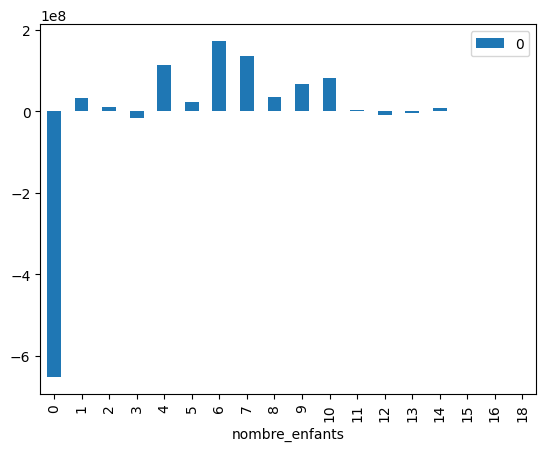

In [41]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    difference = True,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')

In [42]:
scenario.compute_pivot_table(
    aggfunc = 'mean', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    difference = True,
    ).stack().reset_index()

,level_0,nombre_enfants,0
0,impot_revenus,0,-1086.313110
1,impot_revenus,1,557.724365
2,impot_revenus,2,105.042610
3,impot_revenus,3,-139.045258
4,impot_revenus,4,860.527100
5,impot_revenus,5,153.047882
6,impot_revenus,6,1329.935181
7,impot_revenus,7,1180.553833
8,impot_revenus,8,398.738617
9,impot_revenus,9,1125.223877


In [43]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = 2017,
    difference = True,
    ).stack().sum() / 1e9
# The result is close to zero and almost equal to the one computed above

-0.003530048